In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 40
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1982-04-10', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


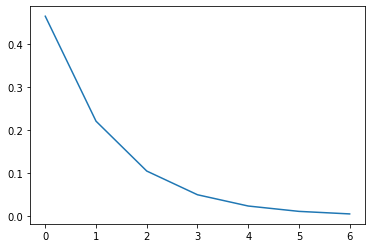

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                      Close              \
        ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
0  116.000000  180.889999  705.900024    NaN  116.000000  180.889999   
1  115.989998  180.759995  705.900024    NaN  115.989998  180.759995   
2  115.830002  180.410004  704.950012    NaN  115.830002  180.410004   
3  116.349998  181.119995  708.020020    NaN  116.349998  181.119995   
4  116.809998  182.250000  711.190002    NaN  116.809998  182.250000   

                            High              ... DayToDayChange  \
         ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  705.900024    NaN  117.019997  180.889999  ...            NaN   
1  705.900024    NaN  117.120003  180.759995  ...            NaN   
2  704.950012    NaN  116.690002  180.410004  ...            NaN   
3  708.020020    NaN  116.860001  181.119995  ...            NaN   
4  711.190002    NaN  117.699997  182.250000  ...            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1             NaN      NaN            NaN            NaN             NaN   
2             NaN      NaN            NaN            NaN             NaN   
3             NaN      NaN            NaN            NaN             NaN   
4             NaN      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

10081   2022-04-04
10082   2022-04-05
10083   2022-04-06
10084   2022-04-07
10085   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                      Close              \
                 ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
Date                                                                            
1982-04-12  116.000000  180.889999  705.900024    NaN  116.000000  180.889999   
1982-04-13  115.989998  180.759995  705.900024    NaN  115.989998  180.759995   
1982-04-14  115.830002  180.410004  704.950012    NaN  115.830002  180.410004   
1982-04-15  116.349998  181.119995  708.020020    NaN  116.349998  181.119995   
1982-04-16  116.809998  182.250000  711.190002    NaN  116.809998  182.250000   

                                     High              ... DayToDayChange  \
                  ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
Date                                                   ...                  
1982-04-12  705.900024    NaN  117.019997  180.889999  ...            NaN   
1982-04-13  705.900024    NaN  117.120003  180.759995  ...            NaN   
1982-04-14  704.950012    NaN  116.690002  180.410004  ...            NaN   
1982-04-15  708.020020    NaN  116.860001  181.119995  ...            NaN   
1982-04-16  711.190002    NaN  117.699997  182.250000  ...            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                    ^W5000    mine1          mine1          mine1   
Date                                                                
1982-04-12             NaN      NaN            NaN            NaN   
1982-04-13             NaN      NaN            NaN            NaN   
1982-04-14             NaN      NaN            NaN            NaN   
1982-04-15             NaN      NaN            NaN            NaN   
1982-04-16             NaN      NaN            NaN            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                     mine1    mine2          mine2          mine2   
Date                                                                
1982-04-12             NaN      NaN            NaN            NaN   
1982-04-13             NaN      NaN            NaN            NaN   
1982-04-14             NaN      NaN            NaN            NaN   
1982-04-15             NaN      NaN            NaN            NaN   
1982-04-16             NaN      NaN            NaN            NaN   

           OvernightChange  
                     mine2  
Date                        
1982-04-12             NaN  
1982-04-13             NaN  
1982-04-14             NaN  
1982-04-15             NaN  
1982-04-16             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.251489883067313
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.251489883067313
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 13.251489883067313
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to ad

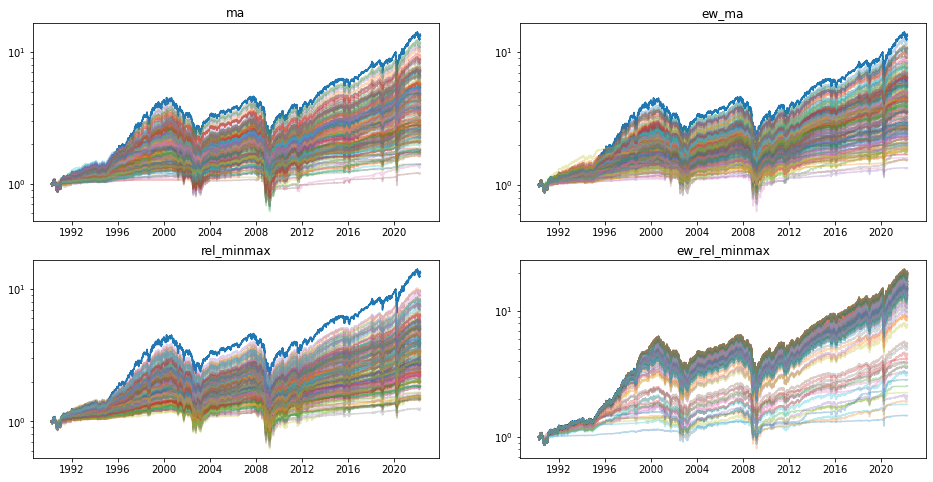

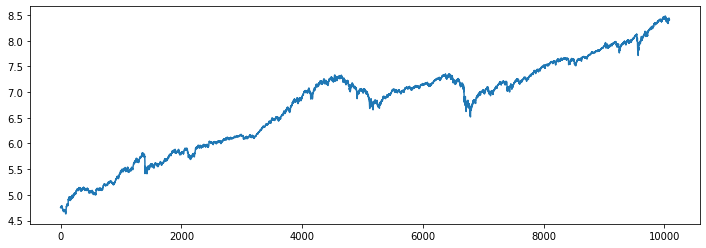

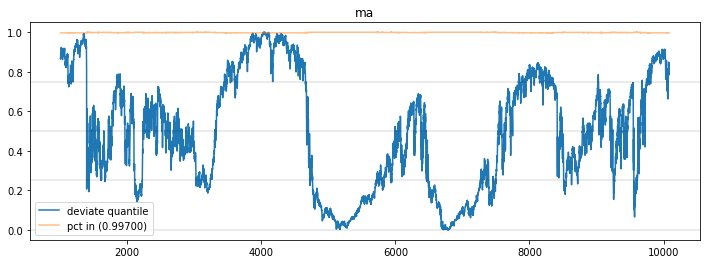

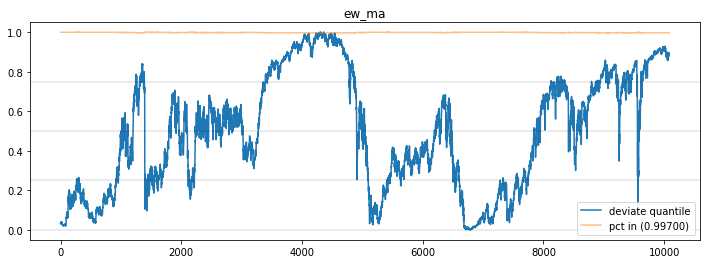

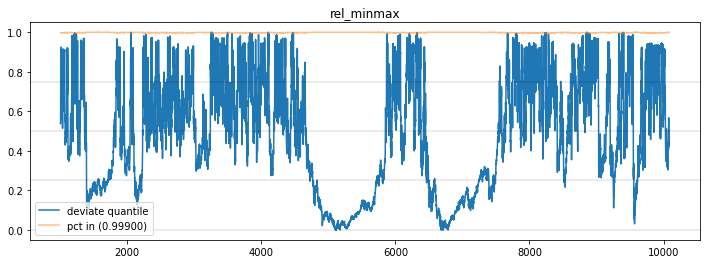

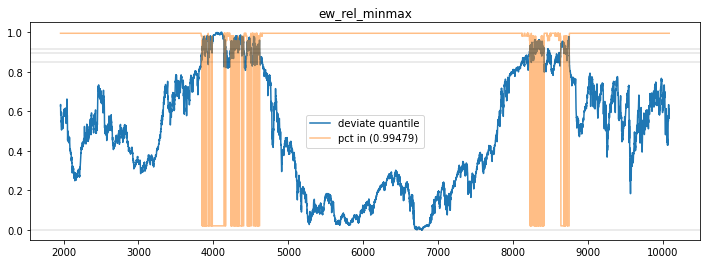

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 31.650506956697306
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 31.650506956697306
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 31.650506956697306
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adj

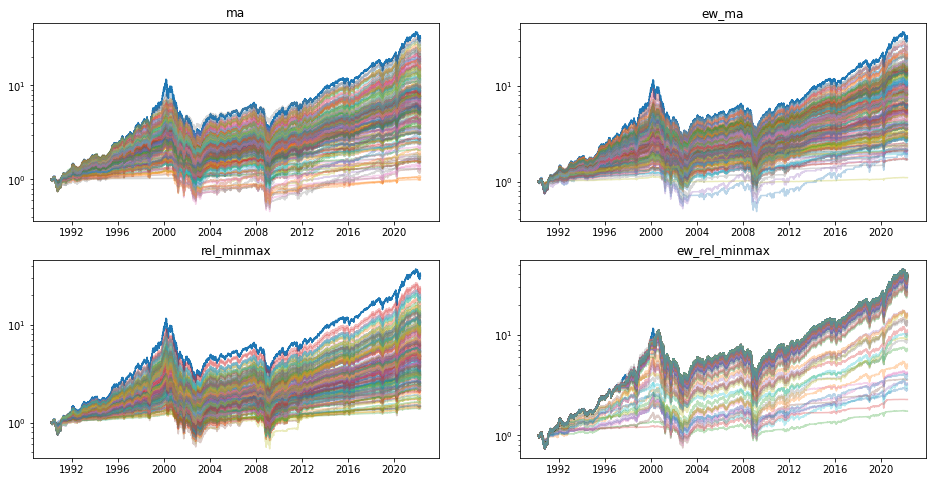

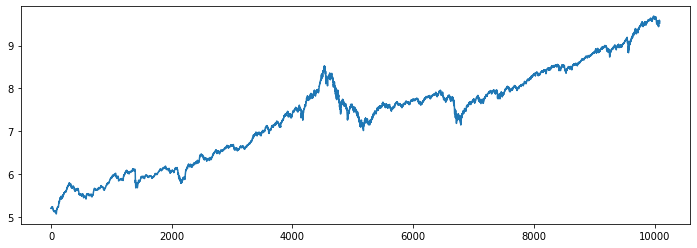

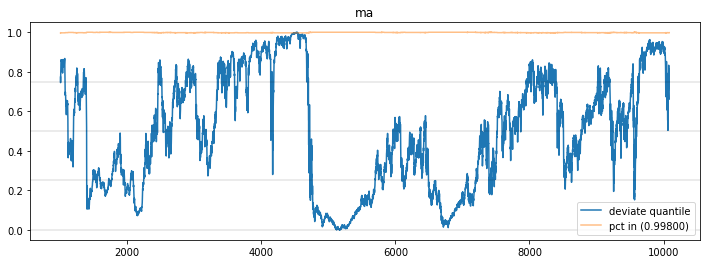

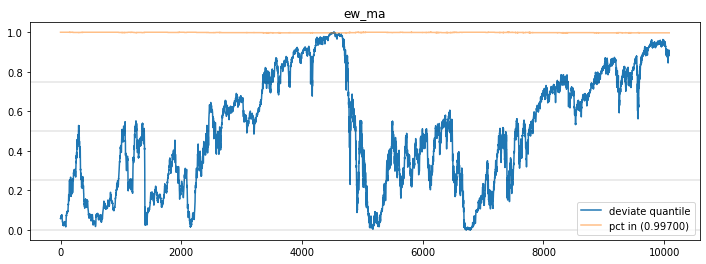

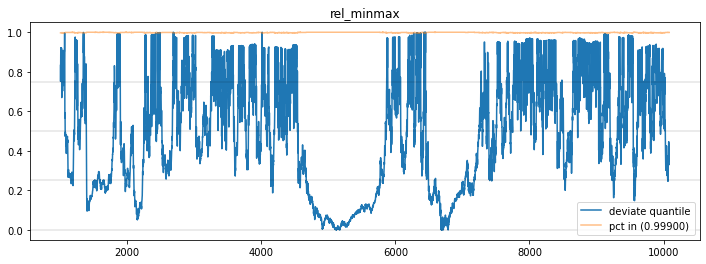

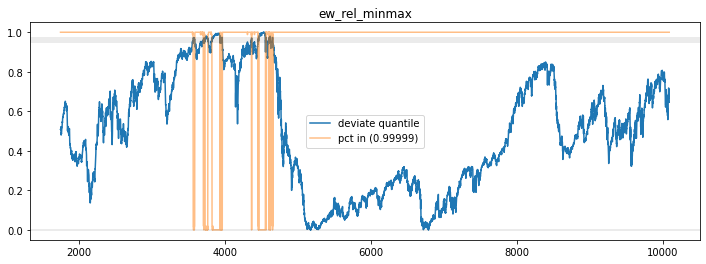

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 8.482561508530825
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 8.482561508530825
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 8.482561508530825
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust.

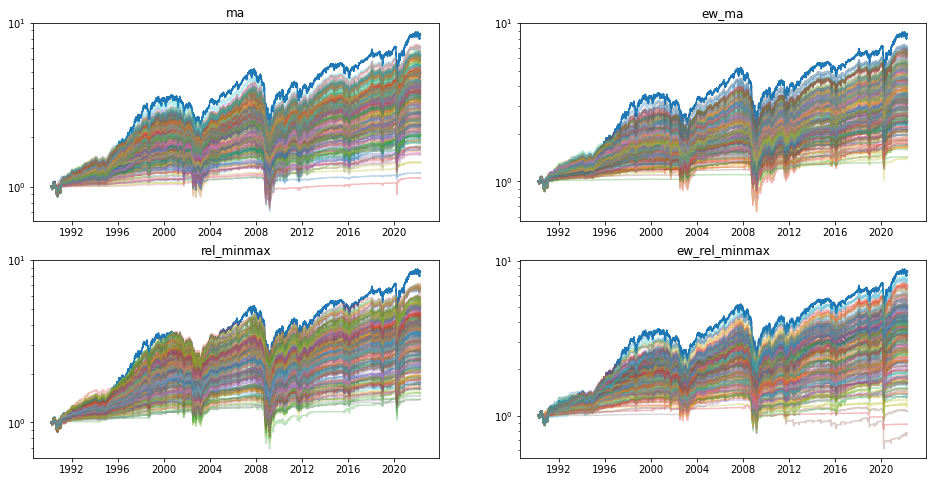

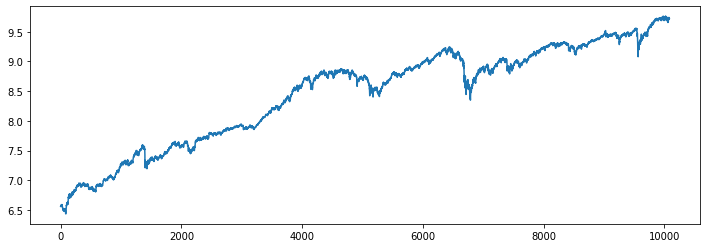

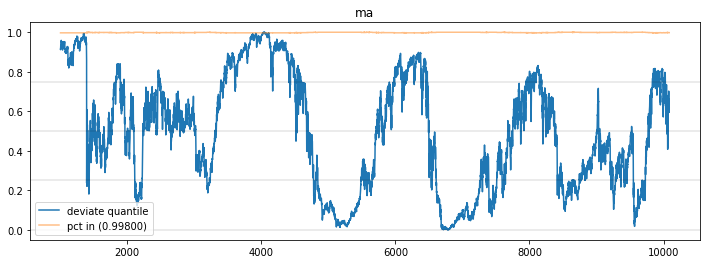

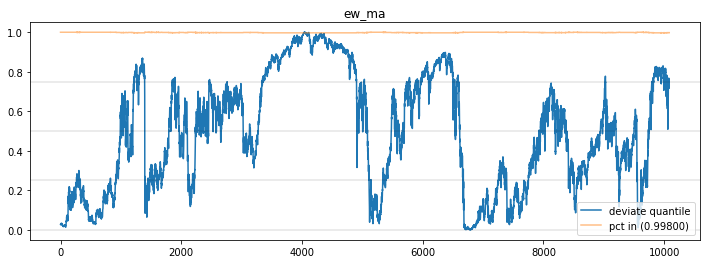

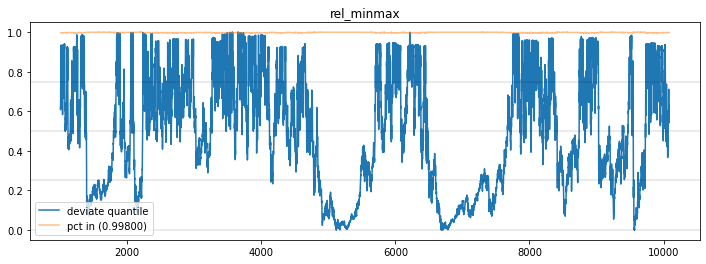

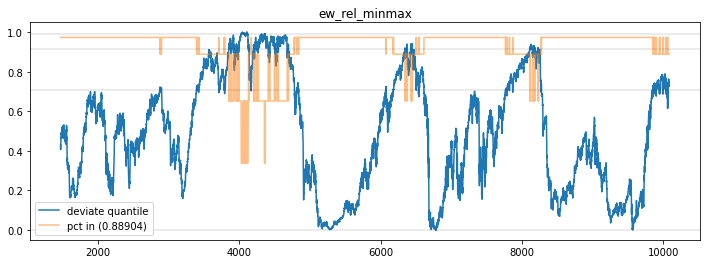

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 8.057323964518156
Refitting current best...
Current best ma returns: 9.777728581796683
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 9.777881271216266
Invested: 1.0
New best: 9.778931072361873
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 8.057323964518156
Refitting current best...
Current best ew_ma returns: 13.449556291558531
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 8.057323964

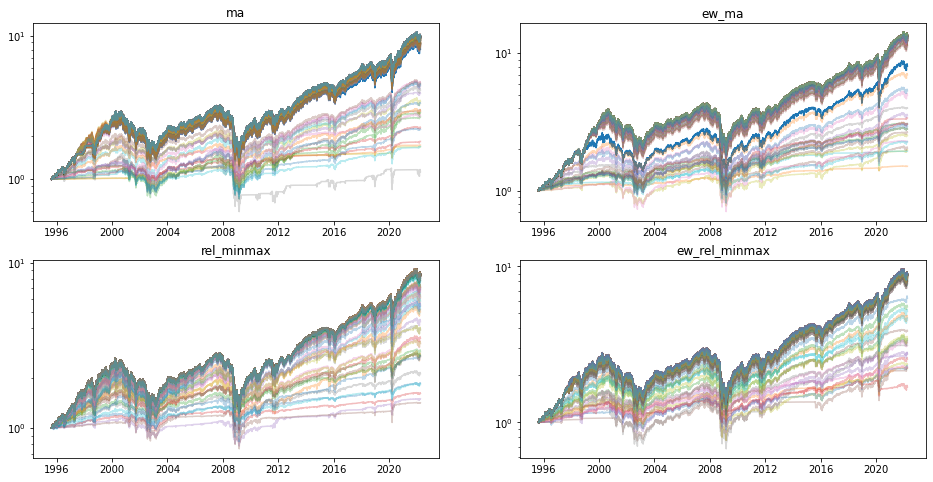

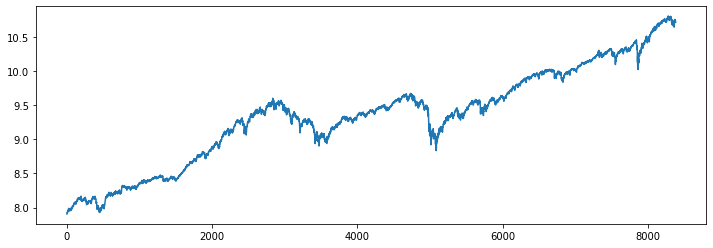

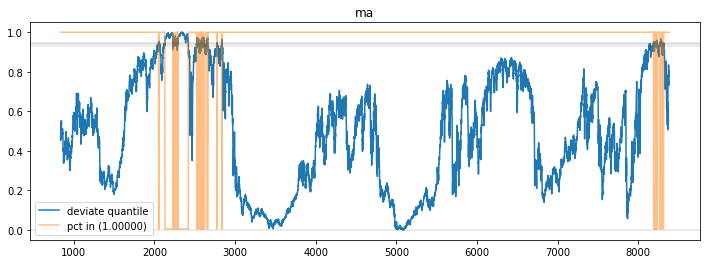

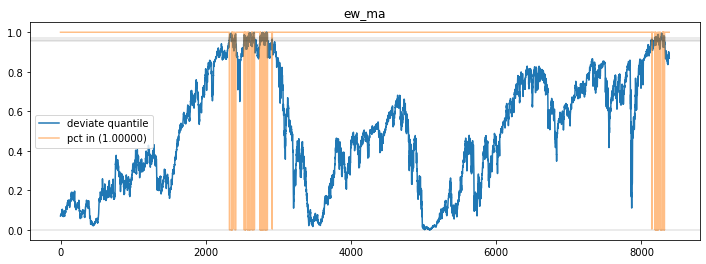

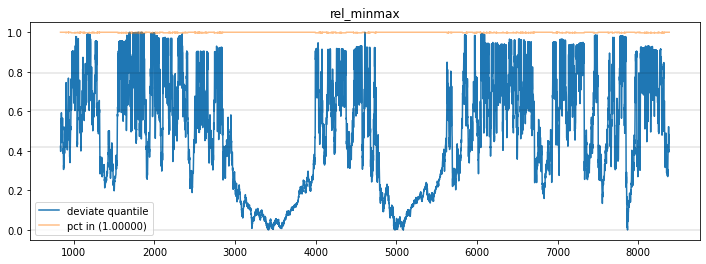

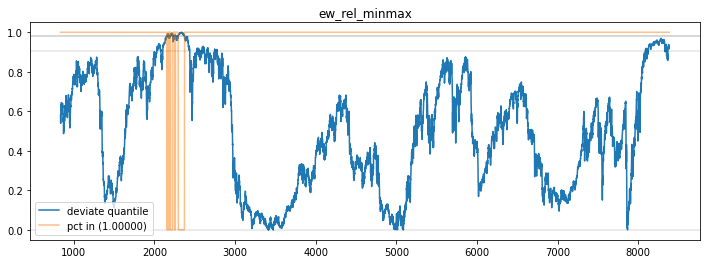

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ma returns: 15.170513409309747
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 15.170526900941512
Invested: 1.0
New best: 15.171136233085623
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ew_ma returns: 16.072142097987918
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 13.47

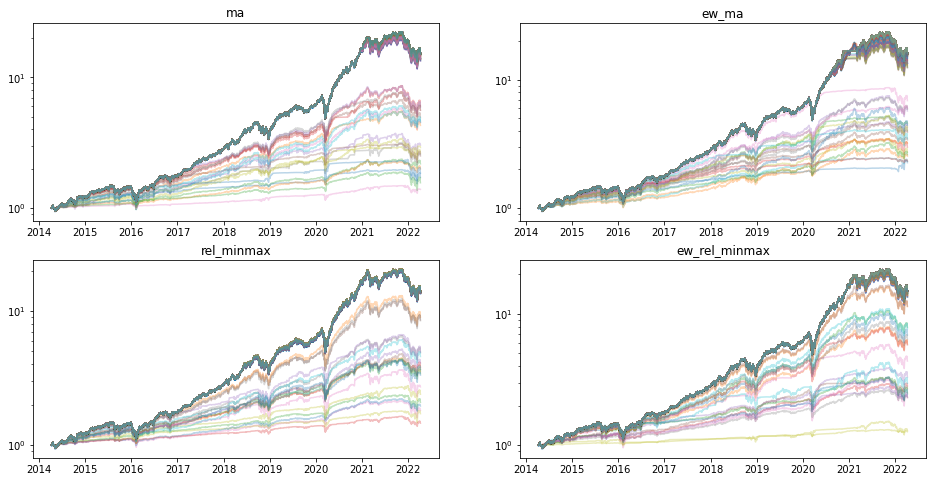

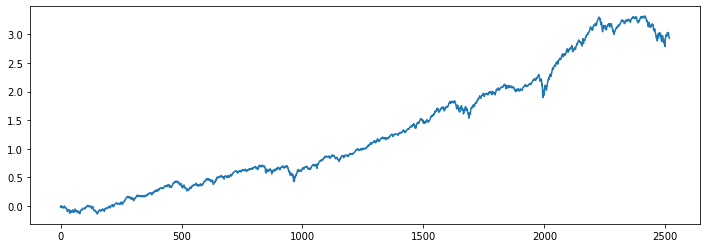

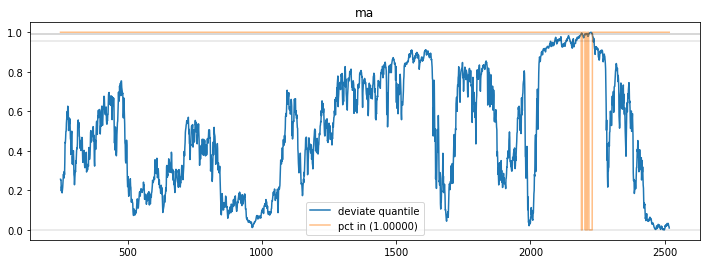

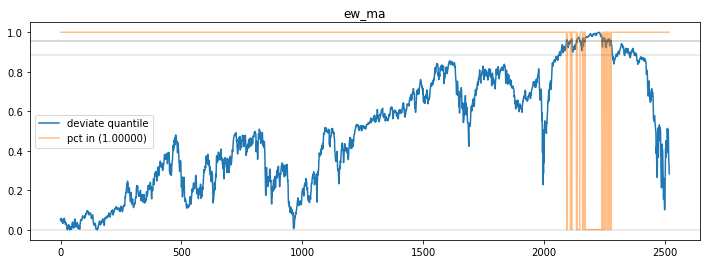

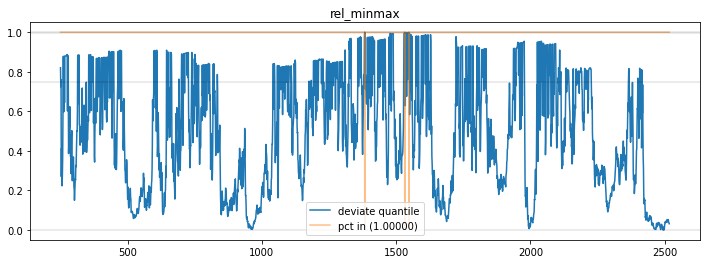

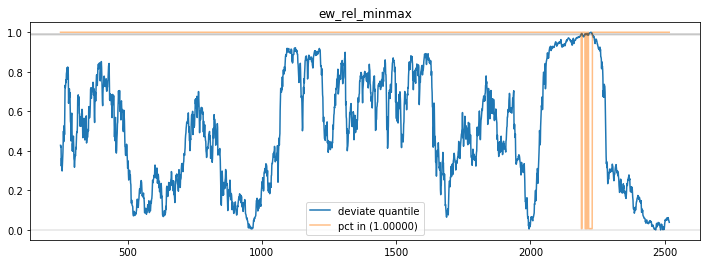

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ma returns: 6.986786820693825
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.986787513455793
Invested: 1.0
New best: 6.987109868609069
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ew_ma returns: 7.152497084596794
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 7.265601732427906
Invested: 1.0
New best: 7.265866104439036
Invested: 1.0
Round: 180


Beginning rel_minmax method...

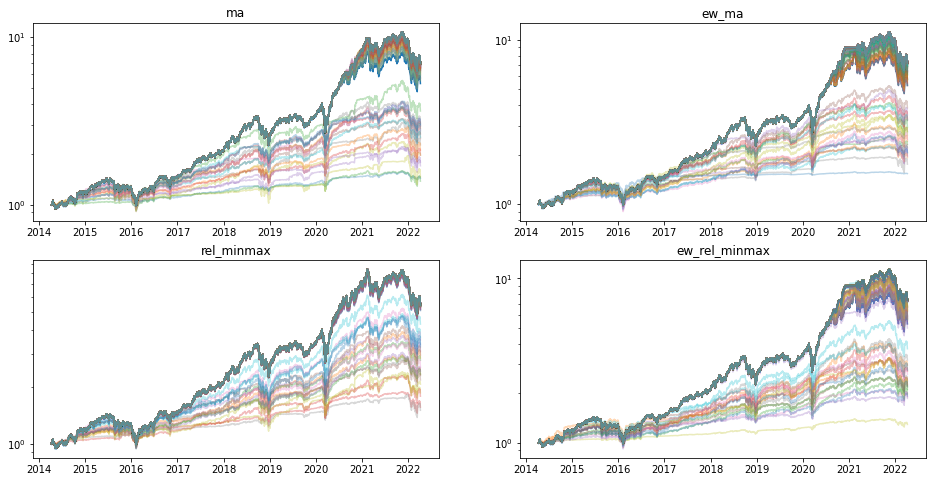

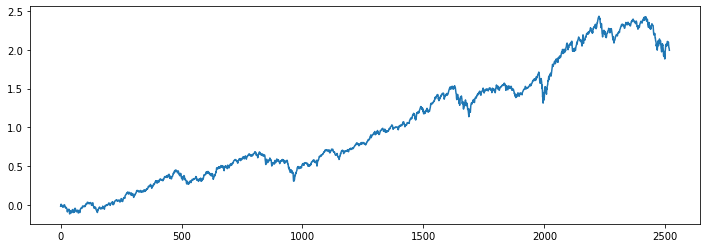

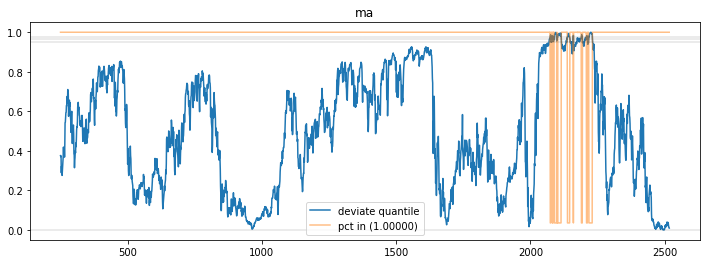

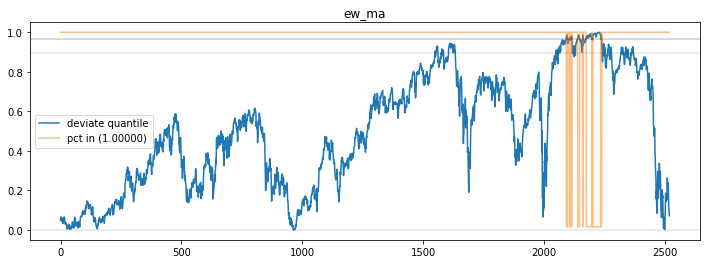

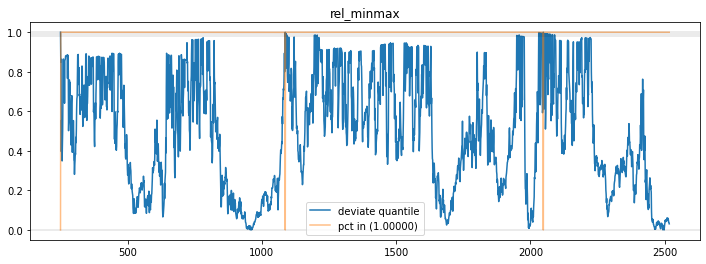

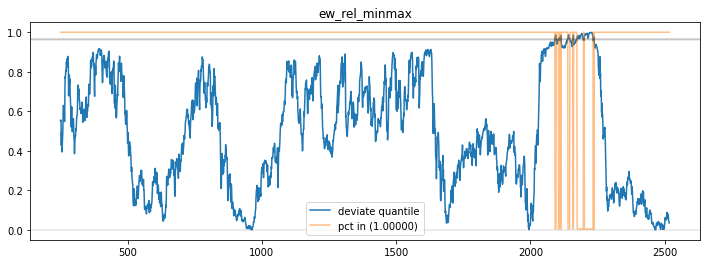

Saving mine2 params...


In [51]:
#N_RAND = 20
#N_ADJ = 180

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [61]:
brakeit()

NameError: name 'brakeit' is not defined

In [57]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [58]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 73.36341652775434 (ew_rel_minmax)
  0.99999987 in
time param: 1668
qs:
(0.0000 - 0.9258): 1.0000
(0.9258 - 0.9340): 1.0000
(0.9340 - 0.9469): 0.9998
(0.9469 - 1.0000): 0.0005

^IXIC:
  Best Return: 112.64249182792159 (ma)
  0.99999253 in
time param: 626
qs:
(0.0000 - 0.8993): 1.0000
(0.8993 - 0.9783): 0.9996
(0.9783 - 0.9865): 0.0007
(0.9865 - 1.0000): 0.0000

^NYA:
  Best Return: 40.01492599091606 (ew_rel_minmax)
  0.99999965 in
time param: 1375
qs:
(0.0000 - 0.8879): 1.0000
(0.8879 - 0.8994): 1.0000
(0.8994 - 0.9111): 0.0003
(0.9111 - 1.0000): 0.0000

^W5000:
  Best Return: 13.541434289772058 (ew_ma)
  1.00000000 in
time param: 837
qs:
(0.0000 - 0.9579): 1.0000
(0.9579 - 0.9625): 1.0000
(0.9625 - 0.9712): 0.0008
(0.9712 - 1.0000): 0.0000

mine1:
  Best Return: 16.076050433121992 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9214): 1.0000
(0.9214 - 0.9561): 1.0000
(0.9561 - 0.9562): 0.9999
(0.9562 - 1.0000): 0.0001

mine2:
  Best Return: 7.984092316747

{'^GSPC': {'best_return': 73.36341652775434, 'pct_in': 0.9999998748328378},
 '^IXIC': {'best_return': 112.64249182792159, 'pct_in': 0.9999925274752438},
 '^NYA': {'best_return': 40.01492599091606, 'pct_in': 0.9999996535408934},
 '^W5000': {'best_return': 13.541434289772058, 'pct_in': 1.0},
 'mine1': {'best_return': 16.076050433121992, 'pct_in': 1.0},
 'mine2': {'best_return': 7.984092316747354, 'pct_in': 1.0}}

In [59]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 73.36341652775434,
  'pct_in': 0.9999998748328378,
  'weight': 5.53623910783781},
 '^IXIC': {'best_return': 112.64249182792159,
  'pct_in': 0.9999925274752438,
  'weight': 3.5589474753764168},
 '^NYA': {'best_return': 40.01492599091606,
  'pct_in': 0.9999996535408934,
  'weight': 4.717316337838925},
 '^W5000': {'best_return': 13.541434289772058,
  'pct_in': 1.0,
  'weight': 1.6806366914628412},
 'mine1': {'best_return': 16.076050433121992,
  'pct_in': 1.0,
  'weight': 0.596708101223135},
 'mine2': {'best_return': 7.984092316747354,
  'pct_in': 1.0,
  'weight': 0.7541239035564913}}

In [60]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [56]:
!say qp is dunzo